In [39]:
import pandas as pd, numpy as np
from vivarium import Artifact

from pathlib import Path

from math import floor

import matplotlib.pyplot as plt

import pdb

from datetime import datetime

pd.options.mode.chained_assignment = None  # default='warn'

In [52]:
FORECASTED_POP_KEY = "population.structure"
SCALING_FACTOR_KEY = "population.scaling_factor"
ACMR_KEY = "cause.all_causes.cause_specific_mortality_rate"
CSMR_KEY = "cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate"
BBBM_INCIDENCE_KEY = "cause.alzheimers.susceptible_to_bbbm_transition_count"
TIME_STEP_YEARS = 1
GBD_AGE_GROUP_YEARS = 5
TIME_STEPS_PER_AGE_GROUP = GBD_AGE_GROUP_YEARS / TIME_STEP_YEARS

SIM_START = 2021
SIM_END = 2100

_location = "United States of America"
ARTIFACTS_DIR = (
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3"
)

BBBM_TESTING_RATES = [
    (2030, 0.1),
    (2035, 0.2),
    (2040, 0.4),
    (2045, 0.6),
    (SIM_END, 0.6),
]

VARIABLE_TREATMENT_INITIATION_RATES = [
    (2030, 0.4),
    (2035, 0.7),
    (SIM_END, 0.7),
]

US_TREATMENT_INITIATION_RATES = [
    (2030, 0.8),
    (SIM_END, 0.8),
]

JAPAN_TREATMENT_INITIATION_RATES = [
    (2030, 0.3),
    (SIM_END, 0.3),
]

TREATMENT_INITIATION_RATES_LOOKUP = {
    "United States of America": US_TREATMENT_INITIATION_RATES,
    "Japan": JAPAN_TREATMENT_INITIATION_RATES,
}

NON_AGE_OBSERVERS = [
    "deaths",
    "exits_to_sim",
    "incidence",
    "age_outs",
    "to_test",
    "new_tests",
    "new_pos_tests",
    "incident_tests",
    "over_thresh",
    "neg_0ya",
    "neg_1ya",
    "neg_2ya",
    "pos",
    "treatment_initiated",
    "treatment_not_initiated",
    "treatment_completed",
    "treatment_discontinued",
]

LOCATIONS = [
    "United States of America",
    "Sweden",
    "China",
    "Japan",
    "Brazil",
    "United Kingdom",
    "Germany",
    "Spain",
    "Israel",
    "Taiwan (Province of China)",
]

In [41]:
def get_bbbm_testing_rate(year):
    years = [year for year, _ in BBBM_TESTING_RATES]
    rates = [rate for _, rate in BBBM_TESTING_RATES]
    if year < years[0]:
        # 0.0 before first year with defined rate
        return 0.0
    elif year > years[-1]:
        return years[-1]
    else:
        return np.interp(year, years, rates)

In [42]:
def get_treatment_inititaion_rate(location, year):
    LOC_SPECIFIC_RATES = TREATMENT_INITIATION_RATES_LOOKUP.get(
        location, VARIABLE_TREATMENT_INITIATION_RATES
    )
    years = [year for year, _ in LOC_SPECIFIC_RATES]
    rates = [rate for _, rate in LOC_SPECIFIC_RATES]
    if year < years[0]:
        return 0.0
    elif year > years[-1]:
        return 0.0
    else:
        return np.interp(year, years, rates)

In [43]:
def load_artifact(location):
    art_filename = f"{location.lower().replace(' ', '_')}.hdf"
    return Artifact(Path(ARTIFACTS_DIR) / art_filename)

In [44]:
def initialize_pop_table(location) -> pd.DataFrame:
    art = load_artifact(location)
    forecasted_pop = (
        art.load(FORECASTED_POP_KEY)
        .query("year_start == 2021 & age_start >=60 & age_start<80")
        .mean(axis=1)
        .droplevel(["location", "year_start", "year_end"])
    )
    all_states_prev = (
        art.load(SCALING_FACTOR_KEY)
        .query("age_start >=60 & age_start<80")  # only 2023 data
        .mean(axis=1)
        .droplevel(["year_start", "year_end"])
    )
    groups = forecasted_pop * (1 - all_states_prev)
    # build table with rows where age_end - age_start = time step (1 year)
    table = pd.DataFrame(
        index=pd.MultiIndex.from_tuples([], names=list(groups.index.names)),
        columns=["over_thresh", "neg_0ya", "neg_1ya", "neg_2ya", "pos", "to_test"],
    )
    for index, value in groups.items():
        (sex, age_start, age_end) = index
        while age_start < age_end:
            table.loc[(sex, age_start, age_start + 1)] = {
                "over_thresh": value / TIME_STEPS_PER_AGE_GROUP,
                # 0% annual testing rate at sim start
                "neg_0ya": 0,
                "neg_1ya": 0,
                "neg_2ya": 0,
                "pos": 0,
                "to_test": 0,  # placeholder for on time step calculations - this should always be 0 once the table is updated
            }

            age_start += 1
    return table

In [45]:
def get_prev_table_index(cur_index):
    (sex, age_start, age_end) = cur_index
    return (sex, age_start - TIME_STEP_YEARS, age_end - TIME_STEP_YEARS)

In [46]:
def increase_person_time_keys(person_time, keys: dict):
    for key, amount in keys.items():
        person_time[key] += amount


def move_people(row, from_col: str, to_col: str, count):
    row[from_col] -= count
    row[to_col] += count


def run_time_step(pop_table, location, year, new_entrants, bbbm_incidence, mortality):
    all_person_times = []
    for index, row in pop_table.iloc[::-1].iterrows():  # iterate ages in reverse order
        (sex, age_start, _) = index

        # initialize observer
        person_time = {
            "location": location,
            "year": year,
            "sex": sex,
            "age_start": age_start,
        }

        for observer_key in NON_AGE_OBSERVERS:
            person_time[observer_key] = 0
            person_time[observer_key] = 0

        # calculate indexes and rates
        prev_index = get_prev_table_index(index)
        lookup_year = min(year, 2050)

        test_rate = get_bbbm_testing_rate(year)

        # 60 YEAR OLDS
        if age_start == 60:
            row[:] = 0  # clear previous years populatoin
            total_incident_60_yos = (
                new_entrants.loc[(sex, lookup_year)] / GBD_AGE_GROUP_YEARS
            )

            # test X% of new 60 yos (will move to "neg 0 y ago" or "positive")
            row.to_test = total_incident_60_yos * test_rate
            # other new 60 yos do not meet propensity threshold
            row.over_thresh = total_incident_60_yos * (1 - test_rate)

            increase_person_time_keys(
                person_time,
                {
                    "incidence": total_incident_60_yos,
                    "incident_tests": total_incident_60_yos * test_rate,
                },
            )
        # OTHER AGES
        else:
            if age_start == 79:  # record people aging out of table
                increase_person_time_keys(
                    person_time, {"age_outs": sum(pop_table.loc[index])}
                )

            # move people into new age groups:
            row = pop_table.loc[prev_index]  # previous age group

            # MORTALITY
            age_group_start = (
                floor((age_start - 1) / GBD_AGE_GROUP_YEARS) * GBD_AGE_GROUP_YEARS
            )  # previous age_start, rounded to GBD age group boundaries

            index_in_groups = (
                sex,
                age_group_start,
                age_group_start + 5,
                lookup_year,
                lookup_year + 1,
            )
            mortality_rate = mortality.loc[index_in_groups]
            increase_person_time_keys(
                person_time, {"deaths": row.over_thresh * mortality_rate}
            )
            row.over_thresh *= 1 - mortality_rate

            # REMOVE THOSE ENTERING SIM (incident to pre-clinical):
            exits_to_sim = bbbm_incidence.loc[index_in_groups] / GBD_AGE_GROUP_YEARS
            row.over_thresh -= exits_to_sim
            increase_person_time_keys(person_time, {"exits_to_sim": exits_to_sim})

            # UPDATE STATES
            delta = test_rate - get_bbbm_testing_rate(year - 1)
            total_age_pop = sum(row)
            # Note: The total age pop denominator we use is important, as well as whether it
            #       includes people who have tested positive.
            # For now, I'm keeping people who test positive in the sim so that they are included
            # in this denominator with the goal of matching "% ever eligible tested" metric
            move_people(row, "over_thresh", "to_test", delta * total_age_pop)
            move_people(row, "neg_2ya", "to_test", row.neg_2ya)
            move_people(row, "neg_1ya", "neg_2ya", row.neg_1ya)
            move_people(row, "neg_0ya", "neg_1ya", row.neg_0ya)

        # if index[0] == "Female" and ((age_start - 60) % 3 == 0):
        #    print(f"{year}, {age_start}: {row.to_test} / {row.sum()}")

        # record number of tests and positive tests
        pos_tests = row.to_test * 0.1  # 10% of tests are false positive
        increase_person_time_keys(person_time, {"new_tests": row.to_test})
        increase_person_time_keys(person_time, {"new_pos_tests": pos_tests})

        # TEST
        move_people(row, "to_test", "pos", pos_tests)
        # remainder are true negative
        move_people(row, "to_test", "neg_0ya", row.to_test)
        # now to_test should be back to zero

        # TREATMENT
        treatment_initiation_rate = get_treatment_inititaion_rate(location, year)
        initiations = pos_tests * treatment_initiation_rate
        non_initiations = pos_tests * (1 - treatment_initiation_rate)
        treatment_completions = initiations * 0.9
        treatment_discontinuations = initiations * 0.1

        # UPDATE COLUMN AND TREATMENT OBSERVERS
        increase_person_time_keys(
            person_time,
            {
                "over_thresh": row.over_thresh,
                "neg_0ya": row.neg_0ya,
                "neg_1ya": row.neg_1ya,
                "neg_2ya": row.neg_2ya,
                "pos": row.pos,
                "treatment_initiated": initiations,
                "treatment_not_initiated": non_initiations,
                "treatment_completed": treatment_completions,
                "treatment_discontinued": treatment_discontinuations,
            },
        )

        # person_times[sex][age_start] = person_times[sex].get(age_start, 0) + row.sum()
        all_person_times.append(person_time)
        pop_table.loc[index] = row

    return all_person_times

In [47]:
def load_background_mortality(location):
    # copied from loader.py
    art = load_artifact(location)
    acmr = art.load(ACMR_KEY)
    csmr = art.load(CSMR_KEY).droplevel(["year_start", "year_end"])

    # for now, assume csmr is the same for all years based on docs
    csmr_all_years = pd.DataFrame(csmr, index=acmr.index)
    return (
        (acmr - csmr_all_years).query("age_start >= 60 & age_start < 80").mean(axis=1)
    )

In [48]:
def load_inc_mort(location):
    # calculate 60 to 61 year olds who are not in simulation for each forecast year
    art = load_artifact(location)
    new_entrants_forecasted = (
        art.load(FORECASTED_POP_KEY)
        .query("age_start == 60")
        .mean(axis=1)
        .droplevel(["location", "age_start", "age_end", "year_end"])
    )
    new_entrants_all_states_prev = (
        art.load(SCALING_FACTOR_KEY)
        .query("age_start == 60")  # only 2023 data
        .mean(axis=1)
        .droplevel(["age_start", "age_end", "year_start", "year_end"])
    )
    new_entrants = new_entrants_forecasted * (1 - new_entrants_all_states_prev)

    background_mortality = load_background_mortality(location)
    # starts in 2022, manually copy 2022 data to 2021
    for index, value in background_mortality.items():
        (sex, age_start, age_end, year_start, year_end) = index
        if year_start == 2022:
            background_mortality.loc[(sex, age_start, age_end, 2021, 2022)] = value

    background_mortality.loc[("Male", 60, 65, 2021, 2022)] = background_mortality.loc[
        ("Male", 60, 65, 2022, 2023)
    ]

    bbbm_incidence_counts = (
        art.load(BBBM_INCIDENCE_KEY)
        .query("age_start >= 60 & age_start < 80")
        .mean(axis=1)
    )
    return (new_entrants, bbbm_incidence_counts, background_mortality)

In [53]:
# person-time observer
person_time = []

for location in LOCATIONS:
    # population table of people in location ages 60-80 who do not have pre-clinical, MCI or AD
    pop_table = initialize_pop_table(location)
    (new_entrants, bbbm_incidence_counts, background_mortality) = load_inc_mort(
        location
    )

    for year in range(SIM_START, SIM_END):
        step_person_times = run_time_step(
            pop_table,
            location,
            year,
            new_entrants,
            bbbm_incidence_counts,
            background_mortality,
        )
        person_time += step_person_times

/tmp/ipykernel_3262599/298073594.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '105436.99080182837' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pop_table.loc[index] = row
/tmp/ipykernel_3262599/298073594.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11715.221200203154' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pop_table.loc[index] = row
/tmp/ipykernel_3262599/298073594.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '108645.57565078328' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pop_table.loc[index] = row
/tmp/ipykernel_3262599/298073594.py:137: FutureWarning: Setting an item of incompa

In [ ]:
VERSION = 1
datestr = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
pt_output = pd.DataFrame(person_time)
pt_output_final = pt_output[
    [
        "location",
        "year",
        "sex",
        "age_start",
        "new_tests",
        "new_pos_tests",
        "treatment_initiated",
    ]
]
pt_output_final["age_group_start"] = 5 * np.floor(pt_output_final["age_start"] / 5)
pt_output_final["age_group_end"] = pt_output_final["age_group_start"] + 5
pt_output_final = pt_output_final.drop(
    "age_start",
    axis=1,
).rename(
    columns={
        "new_tests": "bbbm_test_count",
        "new_pos_tests": "bbbm_positive_test_count",
        "treatment_initiated": "treatment_initiation_count",
        "age_group_start": "age_start",
        "age_group_end": "age_end",
    }
)
pt_output_final = (
    pt_output_final[
        [
            "location",
            "year",
            "sex",
            "age_start",
            "age_end",
            "bbbm_test_count",
            "bbbm_positive_test_count",
            "treatment_initiation_count",
        ]
    ]
    .groupby(["location", "year", "sex", "age_start", "age_end"])
    .sum()
)
pt_output_final

bbbm_test_count  \
location                 year sex    age_start age_end                    
Brazil                   2021 Female 60.0      65.0        0.000000e+00   
                                     65.0      70.0        0.000000e+00   
                                     70.0      75.0        0.000000e+00   
                                     75.0      80.0        0.000000e+00   
                              Male   60.0      65.0        0.000000e+00   
...                                                                 ...   
United States of America 2099 Female 75.0      80.0        1.474025e+06   
                              Male   60.0      65.0        2.326978e+06   
                                     65.0      70.0        1.884853e+06   
                                     70.0      75.0        8.035424e+05   
                                     75.0      80.0        1.374058e+06   

                                                        bbbm_positive_test_count  \
location                 year sex    age_start age_end                             
Brazil                   2021 Female 60.0      65.0                     0.000000   
                                     65.0      70.0                     0.000000   
                                     70.0      75.0                     0.000000   
                                     75.0      80.0                     0.000000   
                              Male   60.0      65.0                     0.000000   
...                                                                          ...   
United States of America 2099 Female 75.0      80.0                147402.523690   
                              Male   60.0      65.0                232697.845407   
                                     65.0      70.0                188485.254780   
                                     70.0      75.0                 80354.240196   
                                     75.0      80.0                137405.750734   

                                                        treatment_initiation_count  
location                 year sex    age_start age_end                              
Brazil                   2021 Female 60.0      65.0                       0.000000  
                                     65.0      70.0                       0.000000  
                                     70.0      75.0                       0.000000  
                                     75.0      80.0                       0.000000  
                              Male   60.0      65.0                       0.000000  
...                                                                            ...  
United States of America 2099 Female 75.0      80.0                  117922.018952  
                              Male   60.0      65.0                  186158.276326  
                                     65.0      70.0                  150788.203824  
                                     70.0      75.0                   64283.392156  
                                     75.0      80.0                  109924.600588  

[6320 rows x 3 columns]

In [106]:
# v&v final output
pt_output_final.loc["United States of America"].sum()

bbbm_test_count               8.376212e+08
bbbm_positive_test_count      8.376212e+07
treatment_initiation_count    6.700969e+07
dtype: float64

Previous results:

'Total BBBM tests conducted from 2021 to 2100: 837611619.3024542'

'Total false positive BBBM tests from 2021 to 2100: 83761161.93024546'

'Total uncessecary treatments initiated from 2021 to 2100: 67008929.544196375'

In [98]:
pt_output_final.to_csv(f"v{VERSION}_{datestr}_outside_sim_results.csv")

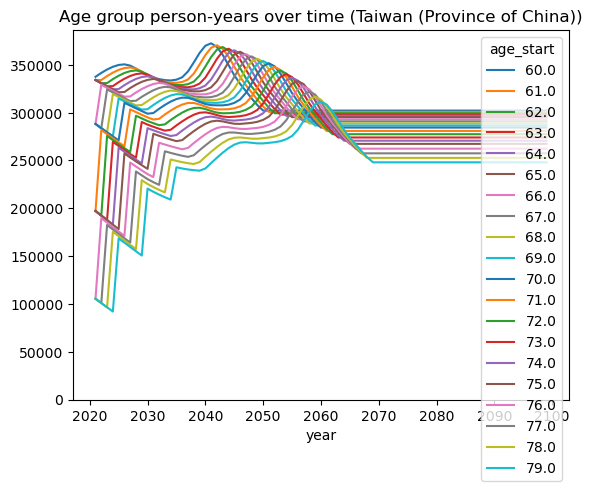

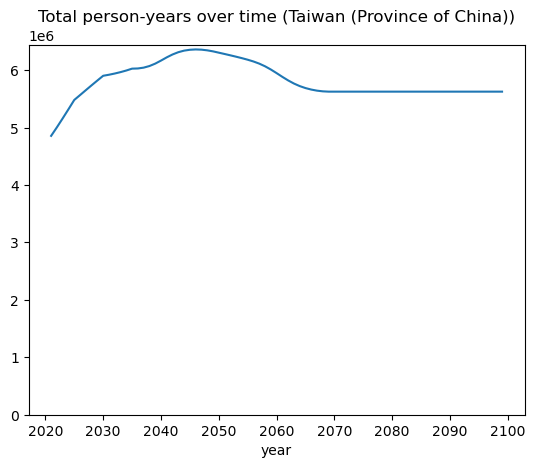

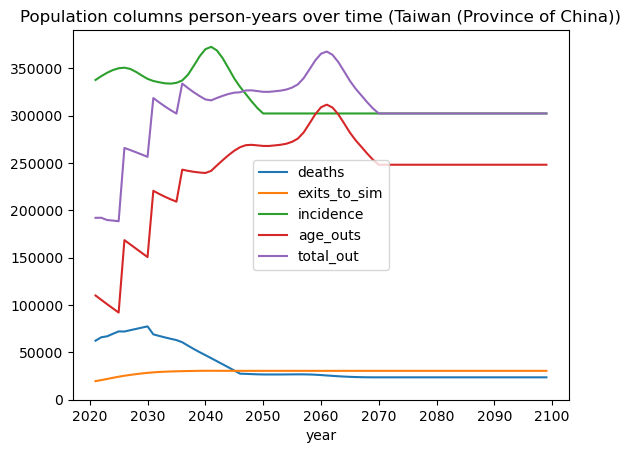

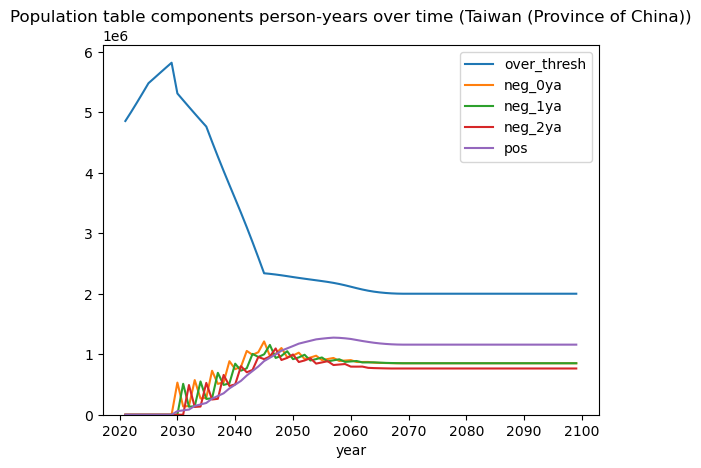

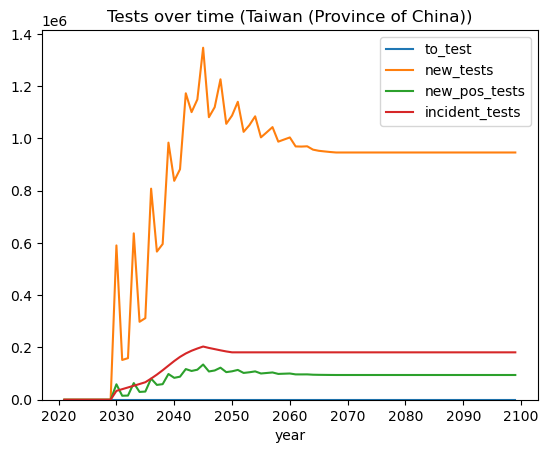

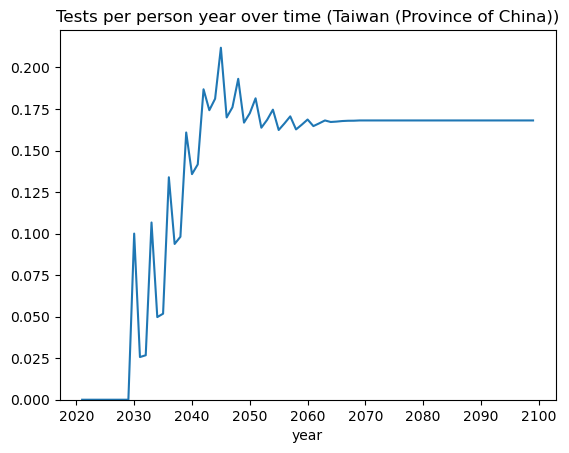

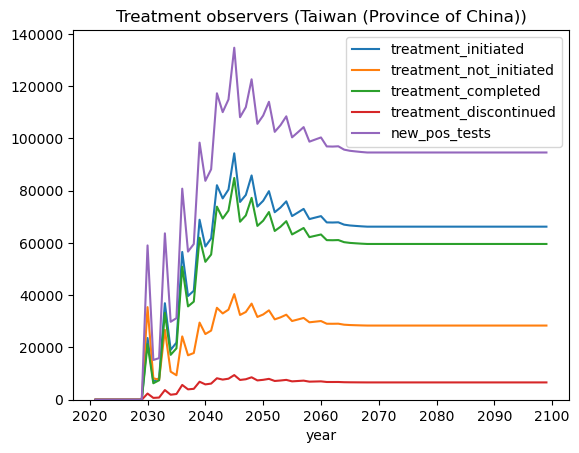

In [82]:
def show_plot(title: str, location: str):
    plt.ylim(bottom=0)
    plt.title(f"{title} ({location})")
    plt.show()


plot_loc = LOCATIONS[9]
pt = pt_output[pt_output["location"] == plot_loc]

pop_cols = ["over_thresh", "neg_0ya", "neg_1ya", "neg_2ya", "pos"]
pt["total_pop"] = pt[pop_cols].sum(axis=1)
pt["total_out"] = pt[["deaths", "exits_to_sim", "age_outs"]].sum(axis=1)

pt.groupby(
    [
        "year",
        "age_start",
    ]
).sum()["total_pop"].unstack().plot()
show_plot("Age group person-years over time", plot_loc)

pt.groupby(["year"]).sum()["total_pop"].plot()
show_plot("Total person-years over time", plot_loc)

pt.groupby(["year"]).sum()[
    ["deaths", "exits_to_sim", "incidence", "age_outs", "total_out"]
].plot()
show_plot("Population columns person-years over time", plot_loc)

pt.groupby(["year"]).sum()[pop_cols].plot()
show_plot("Population table components person-years over time", plot_loc)

pt.groupby(["year"]).sum()[
    ["to_test", "new_tests", "new_pos_tests", "incident_tests"]
].plot()
show_plot("Tests over time", plot_loc)

tmp = pt.groupby(["year"]).sum()
(tmp["new_tests"] / tmp["total_pop"]).plot()
show_plot("Tests per person year over time", plot_loc)

pt.groupby(["year"]).sum()[
    [
        "treatment_initiated",
        "treatment_not_initiated",
        "treatment_completed",
        "treatment_discontinued",
        "new_pos_tests",
    ]
].plot()
show_plot("Treatment observers", plot_loc)

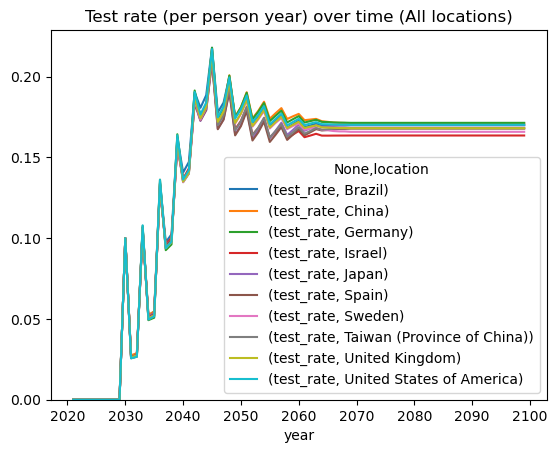

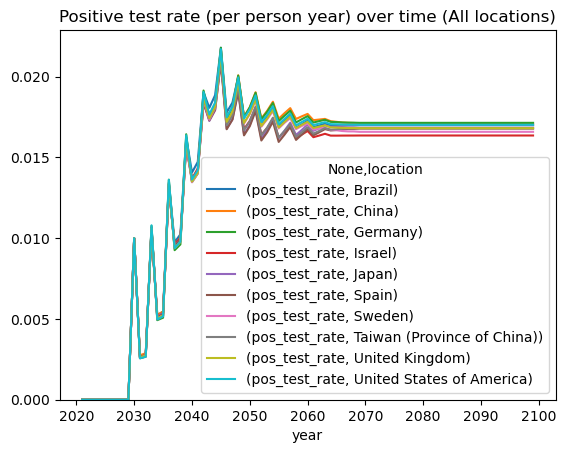

In [76]:
test_rates = pt_output
test_rates["total_pop"] = test_rates[pop_cols].sum(axis=1)
test_rates = test_rates.groupby(["year", "location"]).sum()[
    ["new_tests", "new_pos_tests", "total_pop"]
]
test_rates["test_rate"] = test_rates["new_tests"] / test_rates["total_pop"]
test_rates["pos_test_rate"] = test_rates["new_pos_tests"] / test_rates["total_pop"]

test_rates[["test_rate"]].unstack().plot()
show_plot("Test rate (per person year) over time", "All locations")

test_rates[["pos_test_rate"]].unstack().plot()
show_plot("Positive test rate (per person year) over time", "All locations")

In [47]:
# Calculate total results...
# number of BBBM tests conducted,
display(
    f"Total BBBM tests conducted from {SIM_START} to {SIM_END}: {non_age_observers['new_tests'].sum()}"
)
# number of BBBM tests that are false positives,
display(
    f"Total false positive BBBM tests from {SIM_START} to {SIM_END}: {non_age_observers['new_pos_tests'].sum()}"
)
# number of unnecessary treatments.
display(
    f"Total uncessecary treatments initiated from {SIM_START} to {SIM_END}: {non_age_observers['treatment_initiated'].sum()}"
)

'Total BBBM tests conducted from 2021 to 2100: 434402064.3458911'

'Total false positive BBBM tests from 2021 to 2100: 43440206.43458912'

'Total uncessecary treatments initiated from 2021 to 2100: 34752165.1476713'